# Introduction

In this notebook, we successfully construct two long-only portfolios that outperform the Dow Jones Industrial Average and the S&P 500 over a one year test period, each generating an Alpha greater than 15%. We accomplish this by conducting a network analysis that leverages convex optimization across historical returns from more than 4,600 US stocks dating back to January 2, 2015. The motivation for this project was derived primarily from [this Stanford paper](http://snap.stanford.edu/class/cs224w-2015/projects_2015/Network_Analysis_of_the_Stock_Market.pdf). 

We begin by importing necessary packages.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
%matplotlib inline

We then import our historical data from Yahoo! finance by leveraging a comprehensive list of stock symbols generated by [Samir Kahn](http://investexcel.net/all-yahoo-finance-stock-tickers/) and represented below in the metadata dataframe. We recommend using the [fix_yahoo_finance](https://pypi.python.org/pypi/fix-yahoo-finance) package when pulling the data. 

In [3]:
metadata.head()

,Name,Exchange,Category,Sector
Symbol,,,,
^GSPC,S&P 500,SNP,Index,NaN
^DJI,Dow Jones Industrial Average,DJI,Index,NaN
AAPL,Apple Inc.,NMS,Electronic Equipment,Consumer Goods
BAC,Bank of America Corporation,NYQ,Money Center Banks,Financial
AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses,Services


In particular, we pull adjusted closing prices and keep only those stocks with data for each trading day back to January 2, 2015. A snippet from the resulting dataframe is included below.

In [4]:
data[['AAPL','MSFT','AMZN','^GSPC','^DJI']].head()

,AAPL,MSFT,AMZN,^GSPC,^DJI
Date,,,,,
2015-01-02,103.074181,43.134731,308.519989,2058.199951,17832.99023
2015-01-05,100.170410,42.738068,302.190002,2020.579956,17501.65039
2015-01-06,100.179840,42.110783,295.290009,2002.609985,17371.64063
2015-01-07,101.584595,42.645817,298.420013,2025.900024,17584.51953
2015-01-08,105.487686,43.900375,300.459991,2062.139893,17907.86914


We then calculate log returns and create our training and test sets. Our test set contains a full year of trading data while our training set contains the remaining two years. 

We use our training set to create the correlation matrix that will be leveraged in the construction of our network.     

In [5]:
returns = np.log(data / data.shift(1))[1:]

train = returns[:len(returns)-252]
test = returns[len(returns)-252:]
corr = train.corr()

# Constructing the Network

For our purposes, each node in the network represents a stock, and edges between nodes exist if the correlation of log returns between the two stocks exceeds a given threshold. In our case, we chose a threshold of 50%. The lower one chooses their threshold, the more edges exist, and thus the computation required to analyze the network is increased. Using 50% provides more than 78,000 edges for analysis while preserving computational effeciency on a local machine.  

In [6]:
stocks = list(returns.columns)

G = nx.Graph()
G.add_nodes_from(stocks)
for stock in stocks:
    G.node[stock]['Name'] = metadata.loc[stock, 'Name']
    G.node[stock]['Exchange'] = metadata.loc[stock, 'Exchange']
    G.node[stock]['Industry'] = metadata.loc[stock, 'Category']
    G.node[stock]['Sector'] = metadata.loc[stock, 'Sector']

for first_stock in stocks:
    for second_stock in stocks[stocks.index(first_stock):]:
        if first_stock == second_stock:
            pass
        elif corr.loc[first_stock, second_stock] > 0.5:
            G.add_edge(first_stock, second_stock, weight=corr.loc[first_stock, second_stock])

We visualize the resulting network below using Gephi, color-coding each node according to its sector. 

On the left, we find a disjoint cluster in the basic materials sector composed of companies who provide services related to gold, silver, and other precious metals. These companies have highly correlated returns, but their lack of connectivity to the broader network tells us that their returns are uncorrelated with any of the other equities in our universe. 

Conversely, we see a large amalgamation of equities from different industries in the center of our network. This core is comprised primarily of companies in the financial sector. However, consumer & industrial goods, technology, and services also account for a considerable proportion of the density. 

On the top left of the visualization is a healthcare cluster in teal comprised of biotech companies whose connection with the central mass is weaker, though still existent via a few bridge equities. Similarly, the basic materials cluster on the right of the network represents non-utility energy companies (i.e., oil and gas) covering the value chain from extraction to marketing and sales. 

Finally, the financial-utility cluster at the top right is comprised primarily of electric, gas, and water utilities and various types of REITs. To their right is also a purple cluster of consumer goods companies. 

![Network](Network by Sector.png)

With the network constructed and visualized, we then calculate the normalized centrality measures for each node and assign them accordingly. 

In network analysis, centrality measures are meant to identify "important" nodes. However, what importance means within a network isn't always obvious. Thus, there are a variety of centrality measures, each representing different node attributes. 

The simplest centrality measure is degree centrality, which quantifies the number of edges connected to each node. In our case, stocks with high degree centrality are correlated with many other stocks, suggesting they could serve as useful representatives of those stocks within a portfolio. 

Slightly more complex are closeness and betweenness centrality. Closeness quantifies the average length of the shortest path between a node and all other nodes in the network while betweenness quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Thus, stocks with high closeness centralities tend to be centralized within the network whereas those with high betweenness centralities tend to serve as bridges between groups of similarly performing stocks. 

While their calculations are substantially different, these three measures tend to be correlated. When they aren't, that may mean something interesting. For example, a stock with high degree centrality but low closeness centrality is likely a useful representative within a remote cluster of similarly performing stocks. 

In [7]:
deg_cent = pd.Series(nx.degree_centrality(G))
between_cent = pd.Series(nx.betweenness_centrality(G))
closeness_cent = pd.Series(nx.closeness_centrality(G))

cent = pd.concat([deg_cent, between_cent, closeness_cent], axis=1)
cent.columns = ['D_cent','B_cent','C_cent']

# Normalize the centralities using min-max
normalized_cent = (cent - cent.min()) / (cent.max() - cent.min())

for stock in stocks:
    for col in normalized_cent.columns:
        G.node[stock][col] = float(normalized_cent.loc[stock, col])

At this point, the Stanford group reasoned that to match the performance of the market they should select stocks that are representative of the market itself. This naturally led them to use centrality measures as the criteria for stock selection. In particular, they sought to optimize the weights assigned to each centrality measure in order to maximize the return of the resulting portfolio. This method identified a portfolio that marginally outperformed the S&P 500 over a three year period using only one year of training data, though no additional detail is provided in the paper. 

While impressive, we felt that the Stanford group's method could be further improved by incorporating an important concept in effective portfolio management: diversification. 

To accomplish this, we devised two alternative methods. The first finds disjoint cliques within the network and selects a representative stock from each. The second finds top performing stocks with no connections within the network. 

Before jumping into each method, let's first define some useful functions to simulate and assess the performance of our portfolios. 

# Some Useful Functions

To start, we define a simple function to help us compare the stocks that each method selects in terms of correlation and covariance. 

In [8]:
def compare_stocks(stocks):
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    sns.heatmap(train[stocks].corr(), ax=ax1)
    ax1.set_title('Correlation Matrix')
    sns.heatmap(train[stocks].cov() * 100, ax=ax2)
    ax2.set_title('Covariance Matrix')
    plt.show()

Next, we modify a function from [Thomas Wiecki, Thomas Starke, and David Edwards](https://blog.quantopian.com/markowitz-portfolio-optimization-2/) that uses quadratic programming to calculate the Markowitz efficient frontier given our selected stocks as inputs. For additional background on quadratic programming, check out [Chapter 4 Section 7 of Convex Optimization by Stephen Boyd and Lieven Vandenberghe](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf).

In [9]:
import cvxopt as opt
from cvxopt import blas, solvers

# Turn off progress printing 
solvers.options['show_progress'] = False

def optimal_portfolio(stocks, returns):
    n = len(returns)
    rets = np.asmatrix(returns)
    
    # Create a non-linear grid of 10,000 scalars from 0.1 to 10,000 
    # These scalars serve as weights placed on risk in each optimization
    # -- the larger they are, the more we want risk to be minimized
    N = 10000
    mus = [10 ** (5.0 * t/N - 1.0) for t in range(N+1)]
    
    # Convert returns to cvxopt matrices
    S = opt.matrix(np.cov(rets))                # n x n dense float matrix
    pbar = opt.matrix(np.mean(rets, axis=1))  # n x 1 dense float matrix
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n dense integer identity matrix
    h = opt.matrix(0.0, (n ,1)) # n x 1 dense integer matrix with zeros
    A = opt.matrix(1.0, (1, n)) # 1 x n dense integer matrix with ones
    b = opt.matrix(1.0)         # 1 x 1 dense integer matrix containing one
    
    # The solver is going to use the negative mean return and positive covariance
    # since we're trying to maximize return while minimizing variance
    #   Minimizing: −pbar.T*x + µ*x.T*Σ*x
    #   subject to 1.T*x = 1, x >= 0
    #   where x is the (nx1) vector of weights for each asset within the portfolio 
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    # Calculate risks and returns for frontier
    rets = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    
    # Combine everything into a nice dataframe
    df = pd.DataFrame({x: [weight for weight in portfolios[x]] for x in range(len(portfolios))}).T
    df = df.merge(pd.DataFrame(np.asarray(rets) * 100), left_index=True, right_index=True)
    df = df.merge(pd.DataFrame(np.asarray(risks) * 100), left_index=True, right_index=True)
    df.columns = [stocks + ['means','stds']]
    df.columns = df.columns.map(''.join)        # Fix the multilevel index
    df['sharpes'] = (df.means - benchmark_return) / df.stds * np.sqrt(252)
    
    return df

The plot_simulations function will then create a scatter plot of the efficient frontier color-coded by Sharpe ratio, with the best portfolio highlighted in blue. This function also plots the allocations for each portfolio along the efficient frontier. 

In [10]:
def plot_simulations(ef_results, best_sharpe_index, stocks):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(8)
    
    # Efficient Frontier
    ef_plot = ax1.scatter(x=ef_results['stds'], y=ef_results['means'], c=ef_results['sharpes'], cmap='RdYlGn')
    plt.colorbar(ef_plot, ax=ax1)
    ax1.scatter(x=ef_results.loc[best_sharpe_index,'stds'], y=ef_results.loc[best_sharpe_index,'means'], c='blue', marker='D', 
                s=100)
    ax1.set_ylabel('Mean Expected Daily Return (%)')
    ax1.set_xlabel('Daily Risk (%)')
    ax1.set_title('Efficient Frontier')
    
    # Allocation Plot
    ax2.stackplot(ef_results['means'], ef_results[stocks].T.values * 100, colors=plt.cm.tab20(np.linspace(0,1,20)))
    ax2.axvline(ef_results.loc[best_sharpe_index, 'means'], c='blue')

    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(['Portfolio'] + stocks, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

    ax2.set_ylabel('Allocations (%)')
    ax2.set_xlabel('Mean Expected Daily Return (%)')
    ax2.set_title('Allocation Plot')

    fig.tight_layout()
    plt.show()

The simulate_VaRs function will then simulate the 99% one-day value at risk and associated expected shortfall for our portfolios. By comparing the results alongside the market indicies using the plot_VaRs function, we can gain additional insight into the performance of our portfolios.

For simplicity, we simulate 10,000 next-day prices by sampling returns from a normal distribution.

In [11]:
initial_investment = 1000000

def simulate_VaRs(stocks, optimal_weights, n_simulations):
    prices = {stock: data.iloc[len(data)-252][stock] for stock in stocks}
    shares = {stock: int(optimal_weights.loc[stock] * initial_investment / prices[stock]) for stock in stocks}
    
    VaRs = []
    for simulation in range(n_simulations):
        daily_changes = {}
        for stock in stocks:
            f_return = np.random.normal(train[stock].mean(), train[stock].std())
            f_price = np.exp(f_return + np.log(prices[stock]))
            daily_changes.update({stock: (f_price - prices[stock]) * shares[stock]})
        VaRs.append(sum(daily_changes.values()) / initial_investment * 100)
        
    VaR = np.percentile(VaRs, 0.99)
    ES = np.mean([x for x in VaRs if x <= VaR])
    
    return VaRs, VaR, ES

DJI_VaRs, DJI_VaR, DJI_ES = simulate_VaRs(['^DJI'], pd.Series(1, index=['^DJI']), 10000)
GSPC_VaRs, GSPC_VaR, GSPC_ES = simulate_VaRs(['^GSPC'], pd.Series(1, index=['^GSPC']), 10000)

def plot_hist(ax, portfolio, VaRs, VaR, ES):
    ax.hist(VaRs, bins=100)
    ax.axvline(VaR, color='k')
    ax.text(VaR + 0.1, 275, '{:,.2f}%'.format(VaR))
    ax.axvline(ES, color='red')
    ax.text(VaR + 0.1, 250, '{:,.2f}%'.format(ES), color='red')
    ax.set_xlabel('Simulated Change in Portfolio Value (%)')
    ax.set_ylabel('Frequency')
    ax.legend(['One Day 99% VaR','Expected Shortfall'])
    ax.set_title('Distribution of Daily Portfolio Changes for ' + portfolio)

def plot_VaRs(portfolio, VaRs, VaR, ES):
    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot(211) 
    ax2 = plt.subplot(223) 
    ax3 = plt.subplot(224)
    plot_hist(ax1, portfolio, VaRs, VaR, ES)
    plot_hist(ax2, '^DJI', DJI_VaRs, DJI_VaR, DJI_ES)
    plot_hist(ax3, '^GSPC', GSPC_VaRs, GSPC_VaR, GSPC_ES)
    plt.tight_layout()
    plt.show()

The forward_test function will then take the list of selected stocks and their optimal weights found via the efficient frontier as inputs and produce a line plot of the portfolio's performance vs. the Dow Jones Industrial Average and the S&P 500. This function also creats supplemental plots showing the relative performance of the market indices vs. the portfolio on a monthly basis, as well as the contribution of each component stock in the portfolio. 

In [12]:
def forward_test(stocks, optimal_weights):
    forward_test = optimal_weights * test[stocks]
    forward_test['Portfolio'] = forward_test.sum(axis=1)
    forward_test[['^DJI','^GSPC']] = test[['^DJI','^GSPC']]

    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot(221) 
    ax2 = plt.subplot(223) 
    ax3 = plt.subplot(122) 
    
    # Cumulative Returns
    ax1.plot(forward_test[['Portfolio','^DJI','^GSPC']].cumsum() * 100)
    ax1.legend(['Portfolio','^DJI','^GSPC'])
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.set_title('Forward Test of Network Portfolio vs. Market Indices')
    
    # Relative Returns by Month
    monthly_forward_test = forward_test.resample('M').sum() * 100
    date_index = monthly_forward_test.index.date
    ind = np.arange(len(date_index))
    width = 0.3
    
    rel_ret_df = monthly_forward_test[['^DJI','^GSPC']].sub(monthly_forward_test['Portfolio'], axis=0)
    ax2.bar(ind, rel_ret_df['^DJI'], width, color='orange')
    ax2.bar(ind + width, rel_ret_df['^GSPC'], width, color='green')
    
    ax2.legend(['^DJI','^GSPC'], loc='best')
    ax2.set_xticks(ind + width)
    ax2.set_xticklabels([d.strftime('%Y-%m') for d in date_index], rotation=45)
    ax2.set_ylabel('Relative Return (%)')
    ax2.set_title('Relative Performance of Market Indices vs. Portfolio')
    
    # Contribution of each stock w/in the Portfolio
    ax3.set_prop_cycle('color', plt.cm.tab20(np.linspace(0,1,20)))
    ax3.plot(forward_test[stocks].cumsum() * 100)
    ax3.legend(stocks, ncol=2)
    ax3.set_ylabel('Weighted Cumulative Return (%)')
    ax3.set_title('Contribution of Each Stock in the Portfolio')
    
    fig.tight_layout()
    plt.show()

Finally, we construct four functions used to calculate [traditional measures of portfolio performance: the Sharpe Ratio, the Treynor Ratio, and Jensen's Alpha](https://www.investopedia.com/articles/08/performance-measure.asp). 

The Sharpe Ratio calculates the annualized risk-adjusted return of an asset or portfolio of assets; the Treynor Ratio calculates the annualized excess return that a portfolio generates over that which could have been earned on an investment that has no diversifiable risk; and Jensen's Alpha calculates the annualized excess return that a portfolio generates over its expected return. 

To better understand these metrics, we refer readers to the [capital asset pricing model (CAPM)](https://en.wikipedia.org/wiki/Capital_asset_pricing_model). 

In all cases, we use an annual risk-free return of 5% as our benchmark.

In [13]:
benchmark_return = (1 + 0.05) ** (1 / 252) - 1

# Beta indicates whether a portfolio is more or less volatile than the market as a whole
def calc_beta(portfolio, market):
    return round(np.cov(portfolio, test[market])[0,1] / np.cov(portfolio, test[market])[1,1], 3)

# Sharpe Ratio
def calc_sharpe(stock, benchmark):
    return round((train[stock].mean() - benchmark) / train[stock].std() * np.sqrt(252), 3)

# Treynor Ratio
def calc_treynor(portfolio, market, benchmark):
    beta = calc_beta(portfolio, market) 
    daily_treynor = (portfolio.mean() - benchmark) / beta
    return round(((1 + daily_treynor) ** 252 - 1) * 100, 3)

# Jensen's Alpha
def calc_jensen(portfolio, market, benchmark):
    beta = calc_beta(portfolio, market)
    expected_return = benchmark + beta * (test[market].mean() - benchmark)
    daily_alpha = portfolio.mean() - expected_return
    return round(((1 + daily_alpha) ** 252 - 1) * 100, 3)

With these functions in hand, we can introduce our first method using disjoint cliques. 

# Disjoint Clique Method

The idea is straightforward and largely adapted from [Bowen Yan and Steve Gregory](https://arxiv.org/ftp/arxiv/papers/1202/1202.0480.pdf): identify all disjoint [maximal cliques](https://math.stackexchange.com/questions/758263/whats-maximal-clique) with at least three members, then select the stock from each with the highest centrality score and a cumulative return exceeding 10% over the two year training period. From this list, pick the top 20 according to Sharpe ratio. 

This selection method identifies communities of similarly performing stocks whose joint performance is relatively uncorrelated with the joint performance of other communities within the network. Thus, by selecting representative stocks from each community, we build a portfolio of historically uncorrelated equities. The additional criteria of positive historical performance is used to approximate momentum, which compliments the selection methodology quite well. 

In [15]:
# Find all maximal cliques within the network
maximal_cliques = sorted(list(nx.find_cliques(G)), key=len)

# Get the subset of maximal cliques with at least three nodes
m_cliques = [c for c in maximal_cliques if len(c) >= 3]

# Get the list of unique nodes within the subset of maximal cliques
m_stocks = list(set().union(*m_cliques))

# Generate a subgraph that only contains the nodes in the subset
S = G.subgraph(m_stocks)

# Initialize a list to store our disjoint maximal cliques
disjoint_cliques = []

# Identify disjoint maximal cliques to serve as initial communities.
# If two maximal cliques differ by one element, include the different elements in the final maximal clique
# E.g., [1,2,3,4] and [1,2,3,5] = [1,2,3,4,5]
while m_cliques:
    # Extract the largest maximal clique
    m_clique = m_cliques.pop()
    
    # Subset out any existing 1-cliques
    old_one_cliques = set().union(*[c for c in m_cliques if len(c) == 1])
    
    # Subtract the nodes in the largest maximal clique from all remaining maximal cliques
    m_cliques = sorted([list(set(c) - set(m_clique)) for c in m_cliques], key=len)
    
    # Remove any empty lists
    m_cliques = [c for c in m_cliques if c != []]
    
    # Subset out any new 1-cliques
    new_one_cliques = [c for c in m_cliques if len(c) == 1 and not set(c).issubset(old_one_cliques)]
    
    # Merge them 
    merged_cliques = list(set().union(*new_one_cliques))
    
    # Subtract them from all remaining maximal cliques
    m_cliques = sorted([list(set(c) - set(merged_cliques)) for c in m_cliques], key=len)
    
    # Remove any empty lists
    m_cliques = [c for c in m_cliques if c != []]
    
    # Add them to m_clique
    m_clique += merged_cliques
        
    # Append the largest maximal clique to the list of disjoint maximal cliques
    disjoint_cliques.append(m_clique)
    
# Reduce the number of communities by merging disjoint cliques using an
# ensemble voting approach based on the membership of each node's neighbors 
from collections import Counter

# Sort disjoint_cliques from largest to smallest
disjoint_cliques = sorted(disjoint_cliques, key=len, reverse=True)   

# Assign each stock to a clique in the network
for i in range(len(disjoint_cliques)):
    for stock in disjoint_cliques[i]:
        S.node[stock]['Community'] = i

# Initialize a list to store truly disjoint cliques 
# i.e., cliques whose members have no neighbors outside the clique
truly_disjoint_cliques = []

# Merge disjoint cliques until there are less than 50 communities
while len(disjoint_cliques + truly_disjoint_cliques) > 50:
    # Extract the smallest disjoint clique
    clique = disjoint_cliques.pop()
        
    # Initialize a list to store the membership of each neighbor
    neighbor_cliques = []
    
    # For each stock in the clique, find its neighbors and record their membership
    for stock in clique:
        for n in S.neighbors(stock):
            if n not in clique:
                neighbor_cliques.append(S.node[n]['Community'])
    
    # Identify the most common membership among the neighbors
    if neighbor_cliques or (len(neighbor_cliques) > len(clique)):
        vote = Counter(neighbor_cliques).most_common(1)[0][0] 
    
        # Merge the clique under consideration with its neighbors' most common membership
        merged_cliques = clique + disjoint_cliques[vote]
        disjoint_cliques = sorted([c for c in disjoint_cliques 
                                   if c not in [clique, disjoint_cliques[vote]]] + [merged_cliques],
                                   key = len, reverse=True)
    
    # If there are no outside neighbors, then append the current 
    # clique to the list of truly disjoint cliques
    else:
        truly_disjoint_cliques.append(clique)
        
    # Re-assign each stock to a clique in the network
    for i in range(len(disjoint_cliques)):
        for stock in disjoint_cliques[i]:
            S.node[stock]['Community'] = i

# Merge the new communities with all truly disjoint cliques to finalize the communities
communities = sorted(disjoint_cliques + truly_disjoint_cliques, key = len, reverse=True)

# Finalize the assignment of each stock to a community
for i in range(len(communities)):
    for stock in communities[i]:
        S.node[stock]['Community'] = i

# Identify a representative stock from each community
dc_stocks = []

# Iterate through each community
for com in communities: 
    # Create a subgraph to calculate local centrality scores
    C = S.subgraph(com)
    com_deg_cent = pd.Series(nx.degree_centrality(C))
    
    # Select the stock with the highest centrality and a cumulative return greater than 10%
    for stock in com_deg_cent.sort_values(ascending=False).index:
        if train[stock].cumsum()[-1] > 0.1 and stock not in ['^DJI','^GSPC']:
            dc_stocks.append(stock)
            break
        
# Select the 20 stocks with the largest Sharpe Ratios
top_dc_stocks = list(calc_sharpe(dc_stocks, benchmark_return).nlargest(20).index)

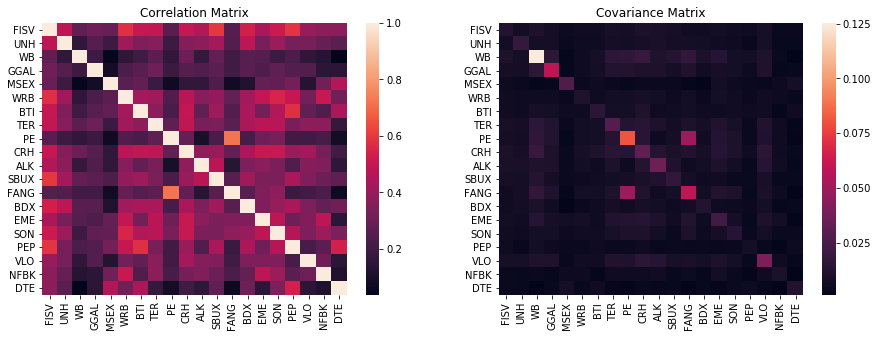

In [16]:
# Plot a heatmap of the correlation and covariance matrices for selected stocks
compare_stocks(top_dc_stocks)

With our stocks selected, we then calculate the efficient frontier and assess the corresponding allocation plot. 

In this case, the largest Sharpe ratio along the efficient frontier was 1.7. We also note that despite selecting 20 stocks for our portfolio, the efficient frontier allocates the entire portfolio to just seven stocks. 

In [17]:
# Calculate the Markowitz efficient frontier 
dc_ef_results = optimal_portfolio(top_dc_stocks, train[top_dc_stocks].T.values)

# Extract the best portfolio from the frontier
best_dc_sharpe_index = np.argmax(dc_ef_results['sharpes'].values)
optimal_dc_weights = dc_ef_results.iloc[best_dc_sharpe_index].loc[top_dc_stocks]

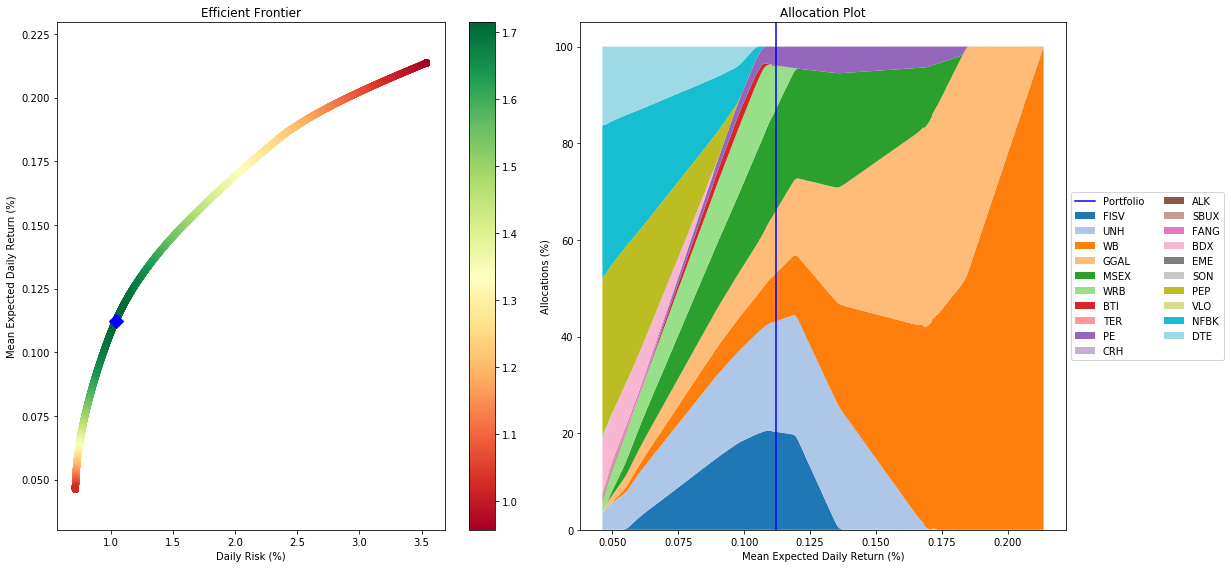

In [18]:
plot_simulations(dc_ef_results, best_dc_sharpe_index, top_dc_stocks)

The portfolio's value at risk is then simulated along with its expected shortfall. Both fall well below the results for the Dow Jones Industrial Average and the S&P 500 -- a good sign, indicating the risk we're taking isn't excessive.

In [19]:
# Calculate the one-day 99% value at risk and expected shortfall
dc_VaRs, dc_VaR, dc_ES = simulate_VaRs(top_dc_stocks, optimal_dc_weights, 10000)

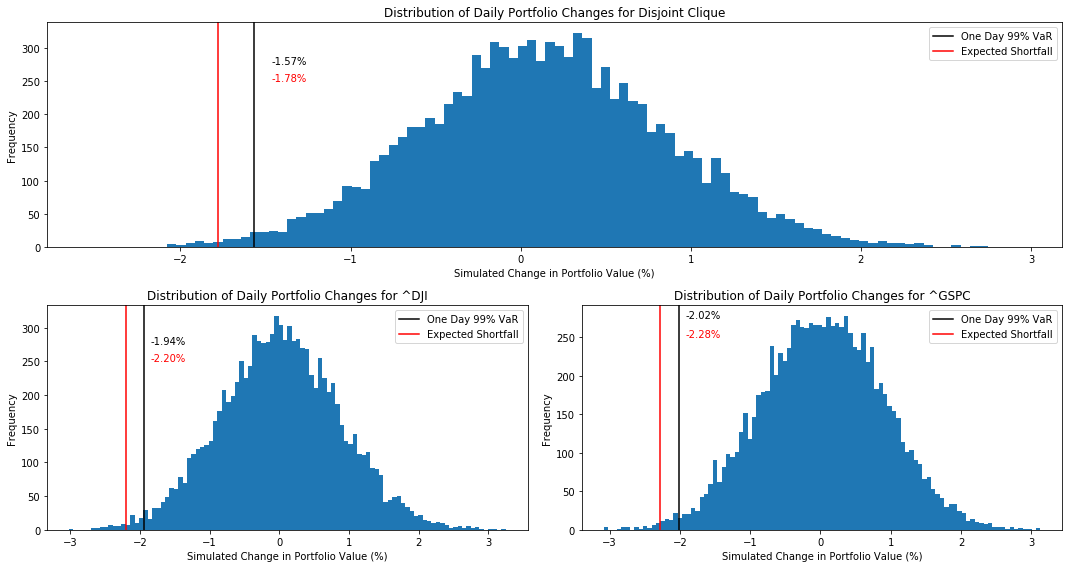

In [20]:
plot_VaRs('Disjoint Clique', dc_VaRs, dc_VaR, dc_ES)

Finally, we forward test the optimal portfolio from this method against both market indices. 

As can be seen in the chart, our disjoint clique method produces a portfolio that ultimately outperforms both indices. In fact, our Alpha using the S&P 500 and a 5% risk free rate is 17.2% over the test period, and our beta is 0.96. However, we also note that this portfolio underperforms both indices three months of out of twelve assessed, suggesting room for further improvement. 

We'll keep the resulting Treynor Ratio of 30 in our back pocket for future reference. 

In [21]:
dc_portfolio = (test[top_dc_stocks] * optimal_dc_weights).sum(axis=1)
print("Alpha: " + str(calc_jensen(dc_portfolio, '^GSPC', benchmark_return)))
print("Beta: " + str(calc_beta(dc_portfolio, '^GSPC')))
print("Treynor Ratio: " + str(calc_treynor(dc_portfolio, '^GSPC', benchmark_return)))

Alpha: 17.166
Beta: 0.957
Treynor Ratio: 30.012


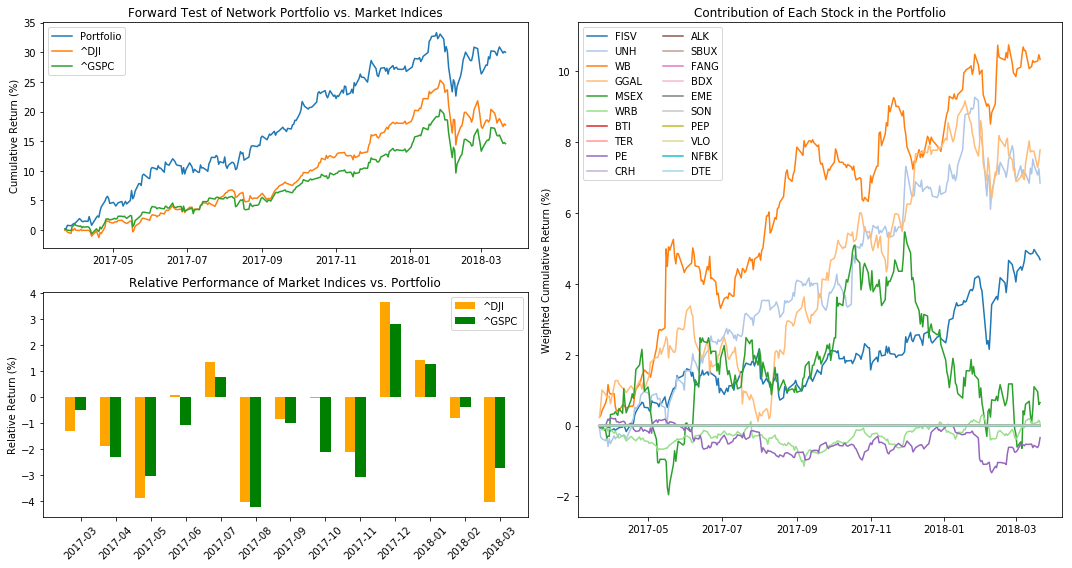

In [22]:
forward_test(top_dc_stocks, optimal_dc_weights)

# Zero Centrality Method

Our second method is much more straightforward: filter the universe of stocks down to those with no connections to the rest of the network, and then sort according to their Sharpe ratio over the training period. 

The selection method ensures minimal correlation and thus ample diversification while prioritizing historical performance. Of course, a large concern is that historical performance is not always indicative of future performance. However, this approach can be easily applied on a regular basis to rebalance as necessary. 

In [23]:
zc_stocks = normalized_cent[normalized_cent == 0].dropna().index
zc_sharpes = calc_sharpe(zc_stocks, benchmark_return)
top_zc_stocks = list(zc_sharpes.nlargest(20).index)

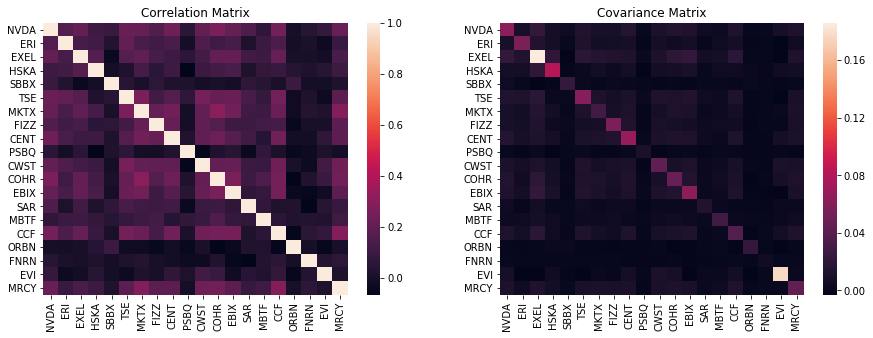

In [24]:
# Plot a heatmap of the correlation and covariance matrices for selected stocks
compare_stocks(top_zc_stocks)

Again, we calculate the efficient frontier and examine the allocations across portfolios. 

In this case, our optimal portfolio achieved a Sharpe ratio greater than 4.95 -- extremely impressive, especially considering no additional research went into the selection methodology. Moreover, our portfolio is well diversified across almost all 20 stocks based on our allocation plot. 

In [25]:
# Calculate the Markowitz efficient frontier 
zc_ef_results = optimal_portfolio(top_zc_stocks, train[top_zc_stocks].T.values)

# Extract the best portfolio from the frontier
best_zc_sharpe_index = np.argmax(zc_ef_results['sharpes'].values)
optimal_zc_weights = zc_ef_results.iloc[best_zc_sharpe_index].loc[top_zc_stocks]

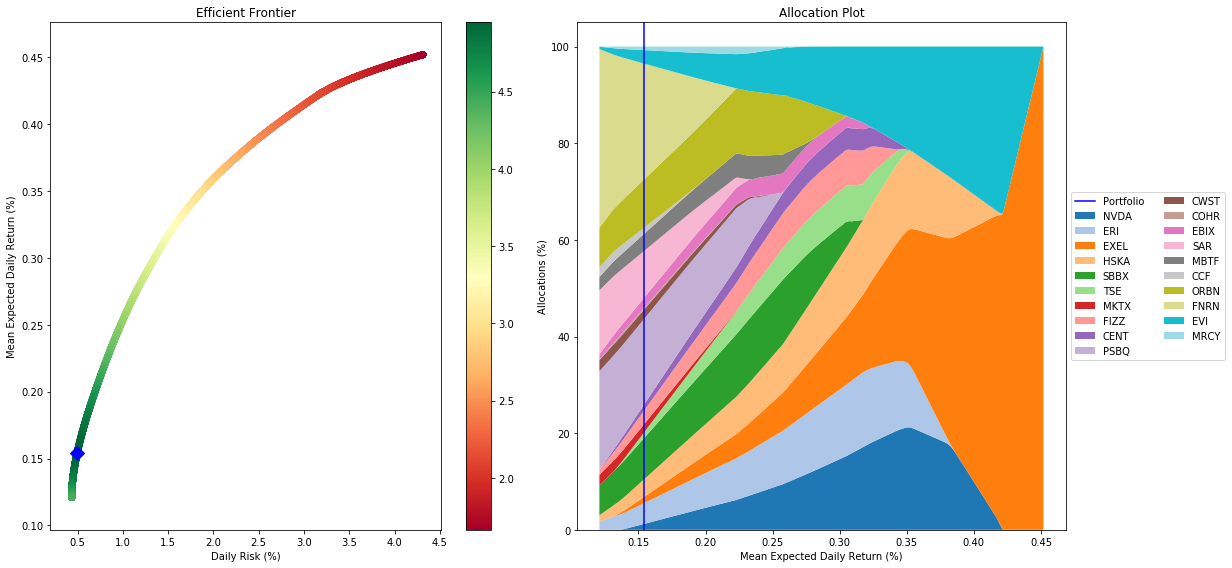

In [26]:
plot_simulations(zc_ef_results, best_zc_sharpe_index, top_zc_stocks)

In [27]:
# Calculate the one-day 99% value at risk and expected shortfall
zc_VaRs, zc_VaR, zc_ES = simulate_VaRs(top_zc_stocks, optimal_zc_weights, 10000)

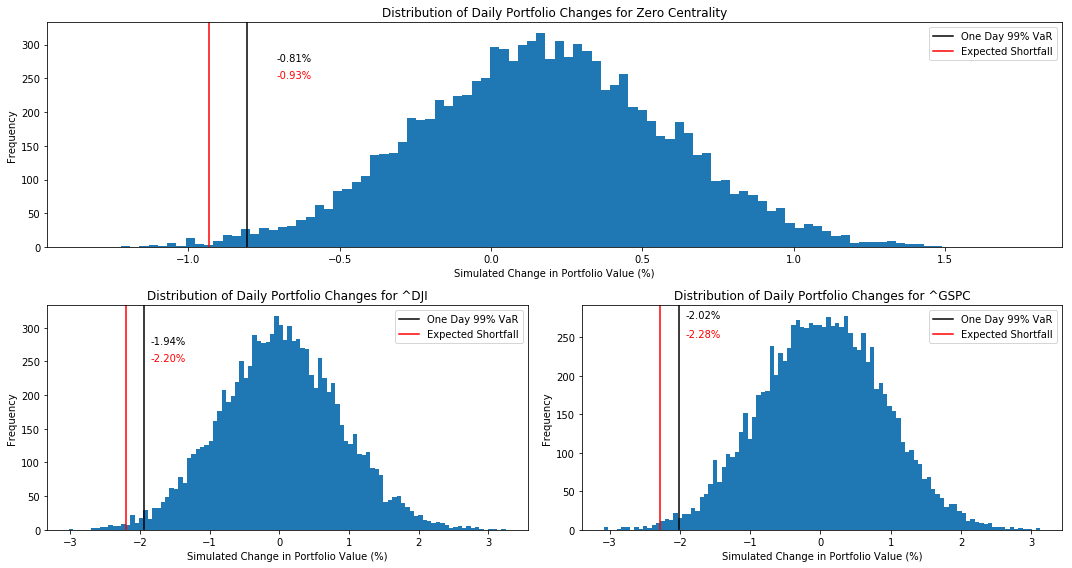

In [28]:
plot_VaRs('Zero Centrality', zc_VaRs, zc_VaR, zc_ES)

When forward testing our zero centrailtiy portfolio against the market indices we observe more consistent outperformance, this time only underperforming both indices two months out of the twelve assessed. However, this portfolio's Alpha is 2% lower than the disjoint clique portfolio over the test period, and its cumulative log return is 10% lower. 

Despite these facts, we note that the zero centrality portfolio's Beta of 0.37 is 260% lower than the disjoint clique method and may therefore be more attractive to a risk-adverse investor. This point is made clearer when comparing both portfolios' Treynor ratios. In particular, the zero centrality portfolio is able to generate 2 times more return per unit of risk than the disjoint clique method. 

In [29]:
zc_portfolio = (test[top_zc_stocks] * optimal_zc_weights).sum(axis=1)
print("Alpha: " + str(calc_jensen(zc_portfolio, '^GSPC', benchmark_return)))
print("Beta: " + str(calc_beta(zc_portfolio, '^GSPC')))
print("Treynor Ratio: " + str(calc_treynor(zc_portfolio, '^GSPC', benchmark_return)))

Alpha: 15.103
Beta: 0.365
Treynor Ratio: 61.932


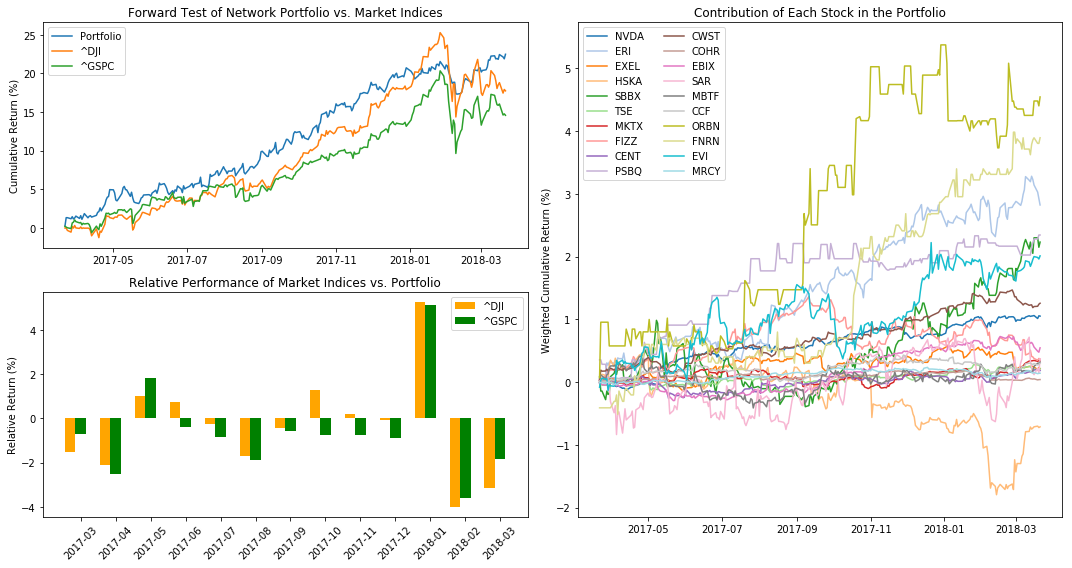

In [30]:
forward_test(top_zc_stocks, optimal_zc_weights)

# Limitations

The limitations of our methods as proposed are many and should be studied further. 

The first and clearest limitation is the lack of sophistication in our selection method employed for our various hyperparameters, including the correlation threshold used to construct the network, the number of stocks selected to comprise each portfolio, and the duration of the training and test periods. A straightforward method for assessing the impact of these choices would be to conduct a sensitivity analysis. 

A second limitation is our universe of ~4,650 stocks. We only examined stocks listed on US exchanges, and thus our methods could benefit from analyzing a broader universe that also includes foreign exchanges. In the same vein, it may also be interesting to assess different asset classes using one network (e.g., equities and bonds). 

A third limitation is our explicit use of the Sharpe ratio as the screen for final stock selection within both methods. While the metric itself isn't a bad choice, the lack of diveristy in our metrics (also known as factors) is potentially worrisome. Other metrics to assess could include value ratios, momentum ratios, and growth ratios. 

# Next Steps

In the coming weeks, we plan to backtest both methods on historical price data back to 2005. We'll rebalance every year and analyze our cumulative performance. In particular, we'll be studying the impact of the '08 recession to see whether our portfolio selection methodlogies fare better than the market indicies. 


# Contact Us

This project was completed by [Florian Singhoff](https://www.linkedin.com/in/florian-singhoff/) and [Chris Becker](https://www.linkedin.com/in/cbecker4/), with help from [Nick Corrie](https://www.linkedin.com/in/nick-corrie/) and [Alex Christian](https://www.linkedin.com/in/alex-christian92/).

Special thanks also to the [Institute for Advanced Analytics](http://analytics.ncsu.edu/) and its faculty. 